Author: Oriol Colomé Font



```
# This is formatted as code
```

# Algorithmic predominant melody extraction in in symphonic music recordings


## Package installation

First of all we need to find out if the notebook is run on Colab and, if so, what version of cuda we have on the server. 

In [ ]:
# If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install mir_eval
!pip install pandas

     |████████████████████████████████| 13.6 MB 4.6 MB/s 
     |████████████████████████████████| 13.1 MB 4.2 MB/s 
     |████████████████████████████████| 5.6 MB 20.0 MB/s 
     |████████████████████████████████| 51 kB 58 kB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 
     |████████████████████████████████| 90 kB 4.7 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=3d75bccf9f03f7c44b4e50e2dc9cb0bc363ef00b23e2f44b464f94e60bfa604c
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64922 sha256=0df51200f200b577d66a50398046003e28d8ab8754543f5e9d9b10365889367c
  Stored in directory: /root/.cache/pip/wheels/c9/aa/16/ce72bc4caa58dfab819e3f46b3542f2bf90a83009f4ea07a48
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100721 sha256=d432dd9af21ea5eb9074188cea9803c307da0822fe50dbab9

We import the packages.

In [ ]:
#Imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import csv
import mirdata
import mir_eval
import essentia.standard as ess
import pandas as pd

# General data processing and visualization

In [ ]:
orchset = mirdata.initialize("orchset")
orchset.license()

========== License ==========
Creative Commons Attribution Non Commercial Share Alike 4.0 International.

******************************************************************************************
DISCLAIMER: mirdata is a software package with its own license which is independent from
this dataset's license. We don not take responsibility for possible inaccuracies in the
license information provided in mirdata. It is the user's responsibility to be informed
and respect the dataset's license.
******************************************************************************************



In [ ]:
!ls

sample_data


In [ ]:
#This cell downloads and validates the orchset dataset
orchset.download()  # download the dataset
orchset.validate()  # validate that all the expected files are there

INFO: Downloading ['all'] to /root/mir_datasets/orchset
INFO: [all] downloading Orchset_dataset_0.zip
311MB [01:44, 3.12MB/s]                           
100%|██████████| 64/64 [00:00<00:00, 65.68it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

Load the track data and its ID

In [ ]:
orchset_ids = orchset.track_ids  # Load orchset IDs
orchset_data = orchset.load_tracks()  # Load orchset data

orchset_data[orchset_ids[0]]  # Visualize a single track

Track(
  audio_path_mono="/root/mir_datasets/orchset/audio/mono/Beethoven-S3-I-ex1.wav",
  audio_path_stereo="/root/mir_datasets/orchset/audio/stereo/Beethoven-S3-I-ex1.wav",
  melody_path="/root/mir_datasets/orchset/GT/Beethoven-S3-I-ex1.mel",
  track_id="Beethoven-S3-I-ex1",
  alternating_melody: ,
  audio_mono: the track's audio (mono)

        Returns,
  audio_stereo: the track's audio (stereo)

        Returns,
  composer: ,
  contains_brass: ,
  contains_strings: ,
  contains_winds: ,
  excerpt: ,
  melody: ,
  only_brass: ,
  only_strings: ,
  only_winds: ,
  predominant_melodic_instruments: ,
  work: ,
)

From here we obtain several information such as a complete list of all different composers featured in the dataset...

In [ ]:
# Get a complete list of all different composers
composer_list = []
for i in orchset_ids:
    composer_list.append(orchset_data[i].composer)
composer_list = np.unique(composer_list)

print(composer_list)

['Beethoven' 'Brahms' 'Dvorak' 'Grieg' 'Haydn' 'Holst' 'Musorgski-Ravel'
 'Profofiev' 'Ravel' 'Rimski-Korsakov' 'Schubert' 'Smetana' 'Strauss'
 'Tchaikovsky' 'Wagner']


...therefore we can check data based on the composer...

In [ ]:
# Create a dictionary using the composers as keys
main_composer_dict = {item: [] for item in composer_list}
for i in orchset_ids:
    main_composer_dict[orchset_data[i].composer].append(orchset_data[i])

main_composer_dict['Beethoven']

[Track(
   audio_path_mono="/root/mir_datasets/orchset/audio/mono/Beethoven-S3-I-ex1.wav",
   audio_path_stereo="/root/mir_datasets/orchset/audio/stereo/Beethoven-S3-I-ex1.wav",
   melody_path="/root/mir_datasets/orchset/GT/Beethoven-S3-I-ex1.mel",
   track_id="Beethoven-S3-I-ex1",
   alternating_melody: ,
   audio_mono: the track's audio (mono)
 
         Returns,
   audio_stereo: the track's audio (stereo)
 
         Returns,
   composer: ,
   contains_brass: ,
   contains_strings: ,
   contains_winds: ,
   excerpt: ,
   melody: ,
   only_brass: ,
   only_strings: ,
   only_winds: ,
   predominant_melodic_instruments: ,
   work: ,
 ), Track(
   audio_path_mono="/root/mir_datasets/orchset/audio/mono/Beethoven-S3-I-ex2.wav",
   audio_path_stereo="/root/mir_datasets/orchset/audio/stereo/Beethoven-S3-I-ex2.wav",
   melody_path="/root/mir_datasets/orchset/GT/Beethoven-S3-I-ex2.mel",
   track_id="Beethoven-S3-I-ex2",
   alternating_melody: ,
   audio_mono: the track's audio (mono)
 
      

...or even check for the opus work of each composer, to name just a few random possibilities we have.

In [ ]:
# Create a work dictionary using the composers as keys
work_dict = {item: [] for item in composer_list}
for i in orchset_ids:
    work_dict[orchset_data[i].composer].append(orchset_data[i].work)

work_dict['Beethoven']

['S3-I',
 'S3-I',
 'S3-I',
 'S3-I',
 'S3-I',
 'S5-I',
 'S5-II',
 'S5-II',
 'S5-II',
 'S7-II',
 'S9-II',
 'S9-II',
 'S9-II']

# Let's now explore how is the data structured

In [ ]:
#Let's explore how is the data structured
main_composer_dict['Beethoven'][0]

Track(
  audio_path_mono="/root/mir_datasets/orchset/audio/mono/Beethoven-S3-I-ex1.wav",
  audio_path_stereo="/root/mir_datasets/orchset/audio/stereo/Beethoven-S3-I-ex1.wav",
  melody_path="/root/mir_datasets/orchset/GT/Beethoven-S3-I-ex1.mel",
  track_id="Beethoven-S3-I-ex1",
  alternating_melody: ,
  audio_mono: the track's audio (mono)

        Returns,
  audio_stereo: the track's audio (stereo)

        Returns,
  composer: ,
  contains_brass: ,
  contains_strings: ,
  contains_winds: ,
  excerpt: ,
  melody: ,
  only_brass: ,
  only_strings: ,
  only_winds: ,
  predominant_melodic_instruments: ,
  work: ,
)

We can extract the mono audio WAV file by using the "audio_path_mono" method.

```
orchset_data[orchset_ids[]].audio_path_mono

```



For exemple:

In [ ]:
audio_sample_mono = orchset_data[orchset_ids[0]].audio_path_mono
audio_sample_mono

'/root/mir_datasets/orchset/audio/mono/Beethoven-S3-I-ex1.wav'

Let's plot it and have a listen to how it sounds:

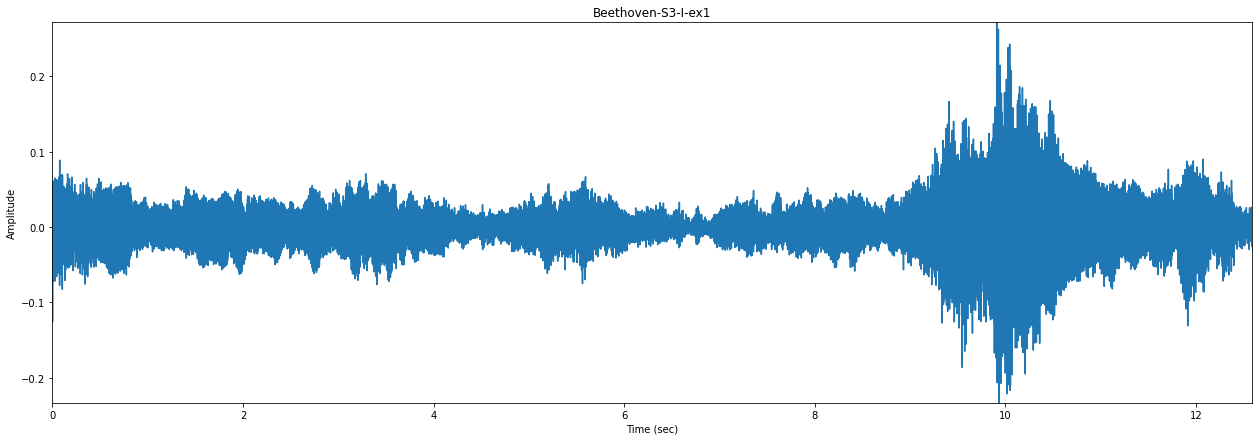

In [ ]:
from scipy.io.wavfile import read
import IPython.display as ipd

fs, x = read(audio_sample_mono)
x = ess.MonoLoader(filename = audio_sample_mono, sampleRate = fs)()

# Plot input sound
plt.figure(figsize=(21.5, 7))
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('Amplitude')
plt.xlabel('Time (sec)')
plt.title(orchset_data[orchset_ids[0]].track_id)
plt.show()

ipd.Audio(audio_sample_mono)

We used Beethoven as a random example, but any composer featured in the data set could have been used. See cell below:

Plot waveforms of random samples for each composer:


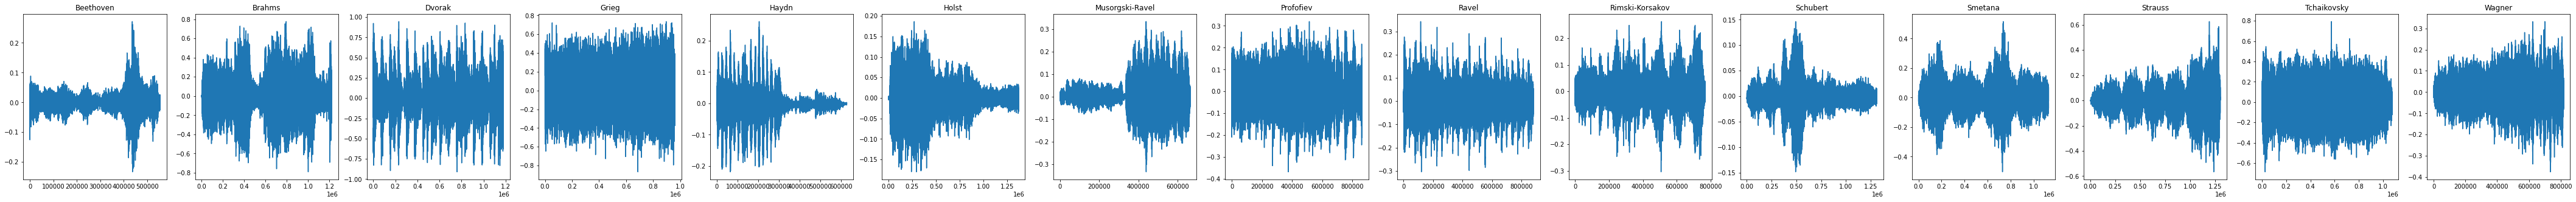

In [ ]:
num_composers = len(main_composer_dict.keys())
print("Plot waveforms of random samples for each composer:")
plt.figure(1, figsize=(int(5*num_composers), 5))
for composer, data in enumerate(main_composer_dict.keys()):
    sample_file = main_composer_dict[data][0].audio_path_mono                        # 0: let's take the first file in the list for sample plots
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1, num_composers,(composer+1))
    plt.plot(x)
    plt.title(data)

# Melody Annotation
The Orchset dataset features reference melodic annotations.
The "F0Data" displays "confidence", "confidence_unit", "frequencies", "frequency_unit", "resample", "time_unit", "times", "to_matrix", "to_mir_eval", "to_multif0", "to_sparse_index", "voicing", and "voicing_unit"


In [ ]:
melody_annotations_sample = orchset_data[orchset_ids[0]].melody #load all the melody features
melody_annotations_sample

F0Data(confidence, confidence_unit, frequencies, frequency_unit, resample, time_unit, times, to_matrix, to_mir_eval, to_multif0, to_sparse_index, voicing, voicing_unit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


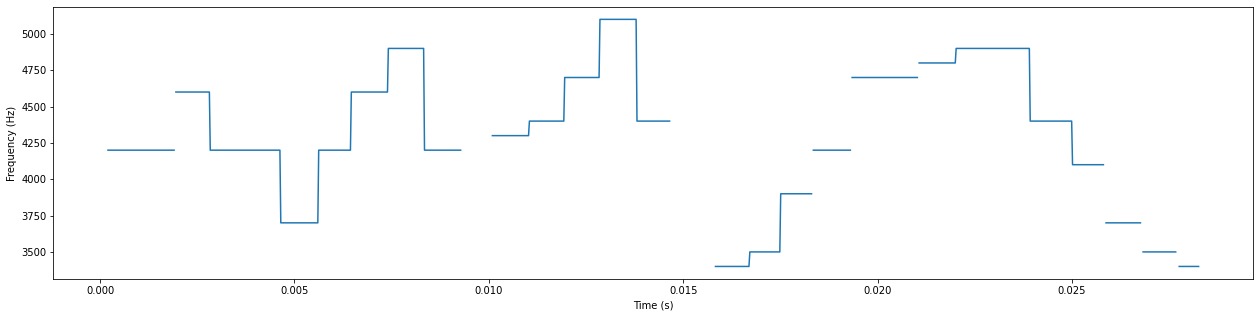

In [ ]:
melody_sample = 1200*np.log2(melody_annotations_sample.frequencies/55.0)
melody_sample[melody_annotations_sample.frequencies<=0] = None
plt.figure(figsize=(21.5,5))
plt.plot(np.arange(melody_sample.size)/float(fs), melody_sample)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

ipd.Audio(audio_sample_mono)

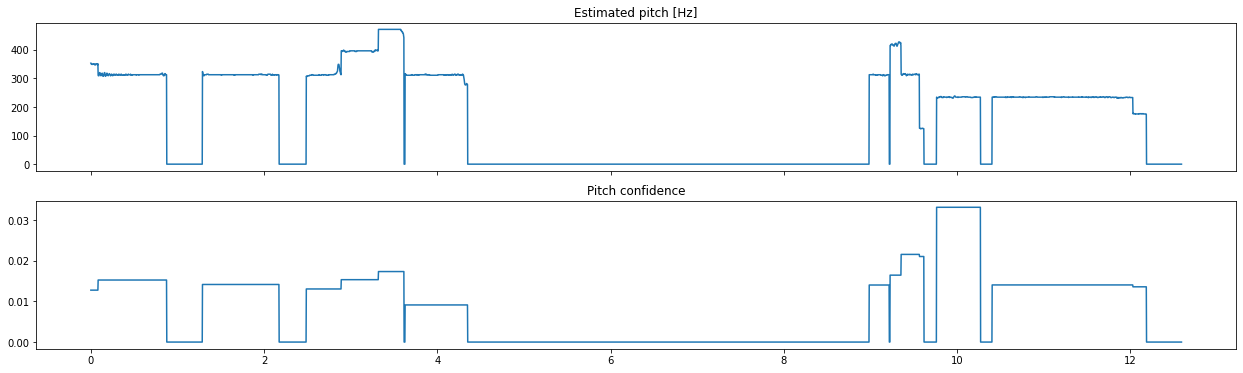

In [ ]:
# Load audio file
loader = ess.EqloudLoader(filename=audio_sample_mono, sampleRate=fs) #It is recommended to apply equal-loudness filter for PitchMelodia
audio = loader()

# Extract the pitch curve. PredominantPitchMelodia takes the entire audio signal as input (no frame-wise processing is required)
pitch_extractor = ess.PredominantPitchMelodia(frameSize=2048, hopSize=128)
pitch_values, pitch_confidence = pitch_extractor(audio)

# Pitch is estimated on frames. Compute frame time positions
timestamps = np.linspace(0.0, len(audio)/float(fs), len(pitch_values))

# Plot the estimated pitch contour and confidence over time
f, axarr = plt.subplots(2, sharex=True, figsize=(21.5,6))
axarr[0].plot(timestamps, pitch_values)
axarr[0].set_title('Estimated pitch [Hz]')
axarr[1].plot(timestamps, pitch_confidence)
axarr[1].set_title('Pitch confidence')
plt.show()

A clearer option is to get rid of the negative values before plotting and display the pitch sequence in cents rather than in Hz. This especially makes sense if we are comparing two or more pitch sequences to each other (e.g. comparing an estimate against a reference).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


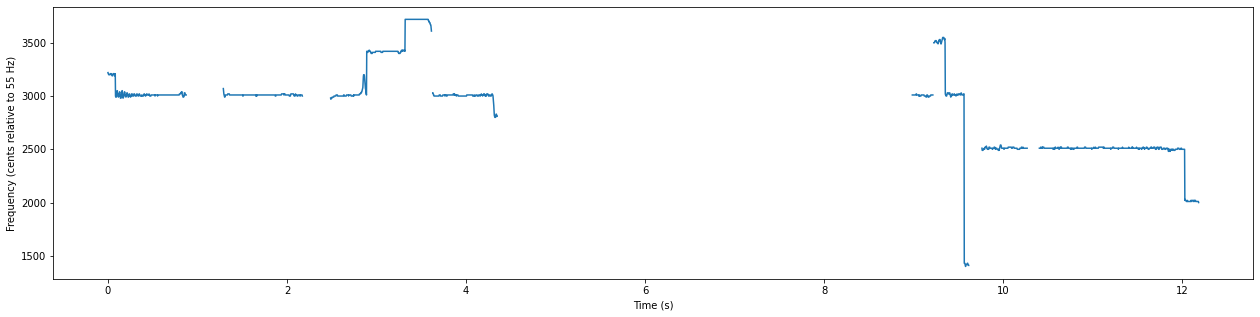

In [ ]:
audio_sample_transcription_cents = 1200*np.log2(pitch_values/55.0)
audio_sample_transcription_cents[pitch_values<=0] = None
plt.figure(figsize=(21.5,5))
plt.plot(timestamps, audio_sample_transcription_cents)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (cents relative to 55 Hz)')

plt.show()

Here we extract the pitch curve per clip. PredominantPitchMelodia takes the entire audio signal as input (no frame-wise processing is required). Then we evaluate the results and we concatenate additional evaluation parameters plus the remaining metadata for each loop.


In [ ]:
rows = []

for i, track in enumerate(orchset_data):
  filename = orchset_data[orchset_ids[i]].audio_path_mono
  to_mir_eval = orchset_data[orchset_ids[i]].melody.to_mir_eval() #Convert units and format to what is expected by mir_eval.melody.evaluate

  loader = ess.EqloudLoader(filename=filename, sampleRate=fs) #It is recommended to apply equal-loudness filter for PredominentPitchMelodia
  audio = loader()

  #Extract the pitch curve. PredominantPitchMelodia takes the entire audio signal as input (no frame-wise processing is required)
  pitch_extractor = ess.PredominantPitchMelodia(frameSize=2048, hopSize=128)
  pitch_values, pitch_confidence = pitch_extractor(audio)


  #Pitch is estimated on frames. Compute frame time positions
  timestamps = np.linspace(0.0, len(audio)/float(fs), len(pitch_values))

  #Evaluate two melody (predominant f0) transcriptions, where the first is treated as the reference (ground truth) and the second as the estimate to be evaluated (prediction).
  evaluation = mir_eval.melody.evaluate(ref_time=to_mir_eval[0], ref_freq=to_mir_eval[1], est_time=timestamps, est_freq=pitch_values, est_voicing=None, ref_reward=None)

  #Extract the details for each loop
  details_dict = {'composer' : orchset_data[orchset_ids[i]].composer,
                  'brass' : orchset_data[orchset_ids[i]].contains_brass,
                  'strings' : orchset_data[orchset_ids[i]].contains_strings,
                  'winds' : orchset_data[orchset_ids[i]].contains_winds,
                  'excerpt' : orchset_data[orchset_ids[i]].excerpt,
                  'brass_only' : orchset_data[orchset_ids[i]].only_brass,
                  'strings_only' : orchset_data[orchset_ids[i]].only_strings,
                  'winds_only' : orchset_data[orchset_ids[i]].only_winds,
                  'predominant' : orchset_data[orchset_ids[i]].predominant_melodic_instruments,
                  'work' : orchset_data[orchset_ids[i]].work}

  #Concatenate the evaluation parameters and the metadata
  item_list = []
  for key, item in evaluation.items():
    item_list.append(item)

  for key, item in details_dict.items():
    item_list.append(item)

  rows.append(item_list)

  print('Evaluation #', int(i+1) , '>>> featured RESULTS >>>', item_list)

Evaluation # 1 >>> featured RESULTS >>> [0.537248028045574, 0.3867924528301887, 0.0, 0.3558282208588957, 0.052125100240577385, 'Beethoven', False, True, True, '1', False, False, False, ['strings', 'winds'], 'S3-I']
Evaluation # 2 >>> featured RESULTS >>> [0.6567622950819673, 0.46153846153846156, 0.020491803278688523, 0.0706967213114754, 0.04669260700389105, 'Beethoven', False, True, True, '2', False, False, False, ['strings', 'winds'], 'S3-I']
Evaluation # 3 >>> featured RESULTS >>> [0.7615894039735099, 0.3818984547461369, 0.048344370860927154, 0.26225165562913905, 0.17982679572083546, 'Beethoven', False, False, True, '3', False, True, False, ['strings'], 'S3-I']
Evaluation # 4 >>> featured RESULTS >>> [0.6149035956227201, 0.2727272727272727, 0.12975508077123502, 0.21730067743616466, 0.146403242147923, 'Beethoven', False, True, True, '5', False, False, False, ['strings', 'winds'], 'S3-I']
Evaluation # 5 >>> featured RESULTS >>> [0.5906089508437271, 0.5723684210526315, 0.114453411592076

In [ ]:
details = ['Composer',
           'Contains Brass',
           'Contains strings',
           'Contains winds',
           'Excerpt',
           'Only brass',
           'Only strings',
           'Only winds',
           'Predominant melodic instruments',
           'Work']

In [ ]:
row = list(evaluation.keys()) + details

In [ ]:
data_file = 'data_pitch.csv'

with open(data_file, 'w') as f:
  # using csv.writer method from CSV package
  write = csv.writer(f)
  write.writerow(row)
  write.writerows(rows)

In [ ]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy,Composer,Contains Brass,Contains strings,Contains winds,Excerpt,Only brass,Only strings,Only winds,Predominant melodic instruments,Work
0,0.537248,0.386792,0.000000,0.355828,0.052125,Beethoven,False,True,True,1,False,False,False,"['strings', 'winds']",S3-I
1,0.656762,0.461538,0.020492,0.070697,0.046693,Beethoven,False,True,True,2,False,False,False,"['strings', 'winds']",S3-I
2,0.761589,0.381898,0.048344,0.262252,0.179827,Beethoven,False,False,True,3,False,True,False,['strings'],S3-I
3,0.614904,0.272727,0.129755,0.217301,0.146403,Beethoven,False,True,True,5,False,False,False,"['strings', 'winds']",S3-I
4,0.590609,0.572368,0.114453,0.381511,0.130994,Beethoven,False,True,True,6,False,False,False,"['strings', 'winds']",S3-I


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Voicing Recall                   64 non-null     float64
 1   Voicing False Alarm              64 non-null     float64
 2   Raw Pitch Accuracy               64 non-null     float64
 3   Raw Chroma Accuracy              64 non-null     float64
 4   Overall Accuracy                 64 non-null     float64
 5   Composer                         64 non-null     object 
 6   Contains Brass                   64 non-null     bool   
 7   Contains strings                 64 non-null     bool   
 8   Contains winds                   64 non-null     bool   
 9   Excerpt                          64 non-null     int64  
 10  Only brass                       64 non-null     bool   
 11  Only strings                     64 non-null     bool   
 12  Only winds              

In [ ]:
data.describe()

,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy,Excerpt
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.00000
mean,0.606959,0.400389,0.198794,0.382692,0.225803,2.75000
std,0.092181,0.224702,0.195193,0.169831,0.187897,2.13809
min,0.418969,0.000000,0.000000,0.043170,0.004076,1.00000
25%,0.544249,0.233971,0.048547,0.250574,0.073193,1.00000
50%,0.602660,0.385165,0.141272,0.372645,0.187298,2.00000
75%,0.661540,0.572236,0.300713,0.512425,0.341441,3.00000
max,0.796410,0.952381,0.696942,0.726768,0.692942,11.00000


In [ ]:
data.nunique()

Voicing Recall                     64
Voicing False Alarm                64
Raw Pitch Accuracy                 59
Raw Chroma Accuracy                64
Overall Accuracy                   64
Composer                           15
Contains Brass                      2
Contains strings                    2
Contains winds                      2
Excerpt                            10
Only brass                          2
Only strings                        2
Only winds                          2
Predominant melodic instruments     8
Work                               25
dtype: int64

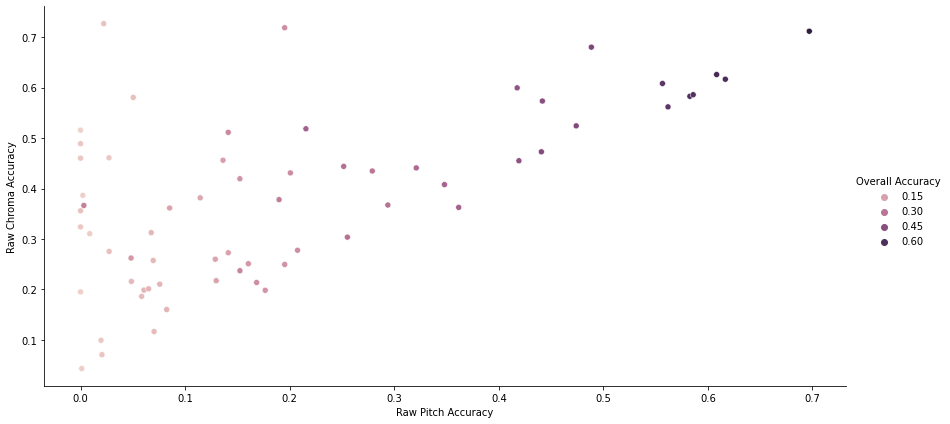

In [ ]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "Raw Pitch Accuracy", y = "Raw Chroma Accuracy", hue = 'Overall Accuracy', data = data, height=6, aspect=2)

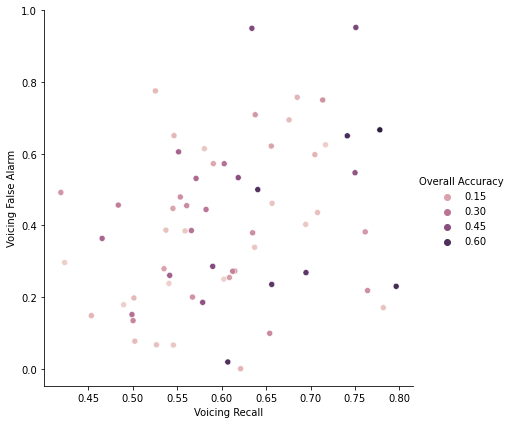

In [ ]:
sns.relplot(x = "Voicing Recall", y = "Voicing False Alarm", hue = 'Overall Accuracy', data = data, height=6, aspect=1)

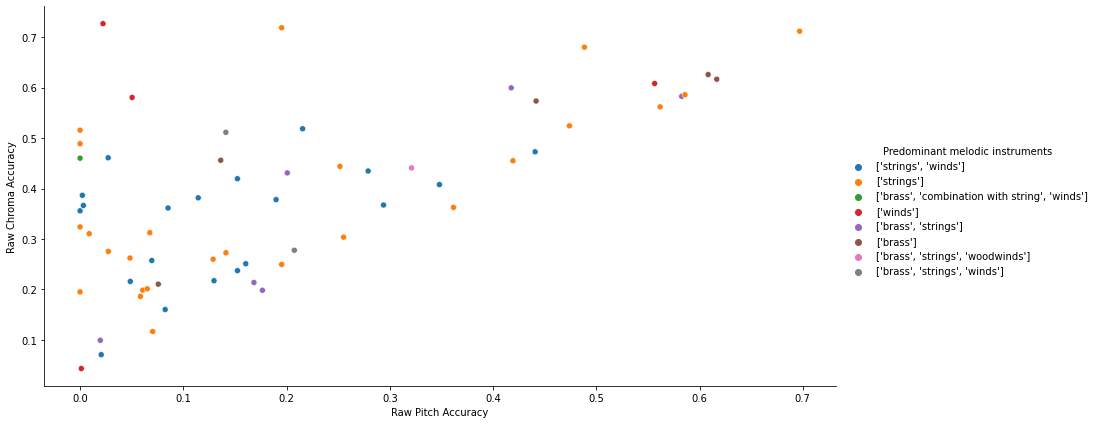

In [ ]:
sns.relplot(x = "Raw Pitch Accuracy", y = "Raw Chroma Accuracy", hue = 'Predominant melodic instruments', data = data, height=6, aspect=2)

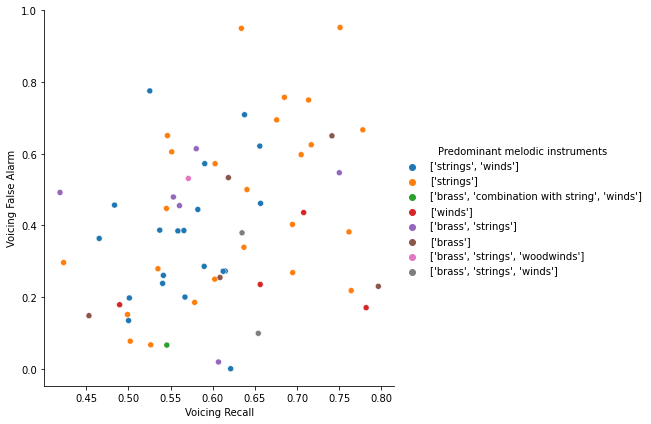

In [ ]:
sns.relplot(x = "Voicing Recall", y = "Voicing False Alarm", hue = 'Predominant melodic instruments', data = data, height=6, aspect=1)

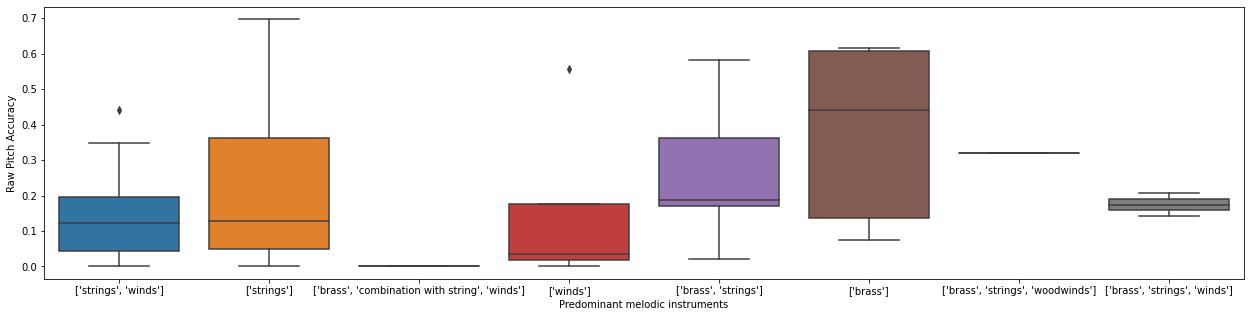

In [ ]:
plt.figure(figsize=(21.5,5))
sns.boxplot(x="Predominant melodic instruments", y="Raw Pitch Accuracy", data=data)
plt.show()

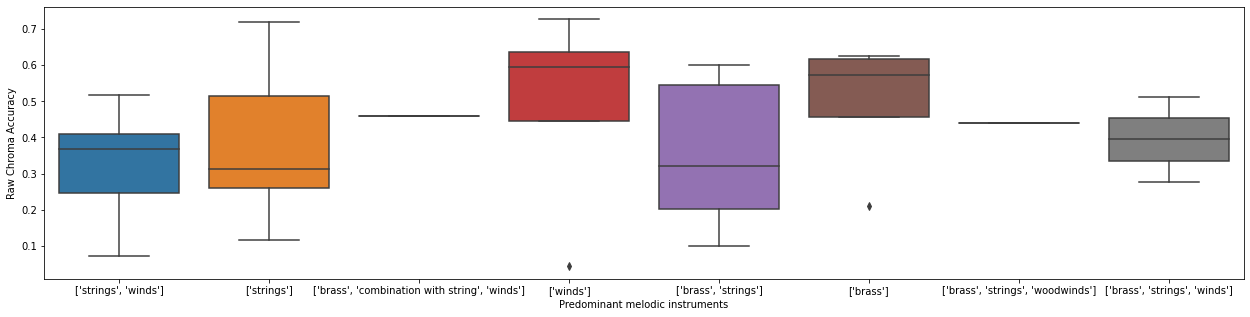

In [ ]:
plt.figure(figsize=(21.5,5))
sns.boxplot(x="Predominant melodic instruments", y="Raw Chroma Accuracy", data=data)
plt.show()